In [1]:
import numpy as np
import matplotlib.pyplot as plt

from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains
from pymoo.decomposition.asf import ASF
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ManipulabilityReward, ForceEllipsoidReward, ZRRReward, MinForceReward, MinManipulabilityReward,DexterityIndexReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward, EndPointIMFReward,ActuatedMassReward, TrajectoryIMFReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L
from auto_robot_design.optimization.saver import (
    load_checkpoint,
)

Praise the Gods for ChatGPT that helps us to create simple way to make directory choosing interface.

In [2]:
import tkinter as tk
from tkinter import filedialog

def select_directory():
    # Create a root window
    root = tk.Tk()
    # Hide the root window
    root.withdraw()
    # Make the root window the topmost window
    root.call('wm', 'attributes', '.', '-topmost', True)
    # Open directory dialog and store the selected directory path
    directory_path = filedialog.askdirectory(initialdir="./",
        title="Select a directory"
    )
    root.update_idletasks() 
    root.destroy()
    # Check if a directory was selected
    if directory_path:
        #print(f"Selected directory: {directory_path}")
        return directory_path
    else:
        #print("No directory selected")
        return None

# Call the function to open the directory dialog
selected_directory = select_directory()
print(f"Resulting directory path: {selected_directory}")

Resulting directory path: D:/work/projects/mechanism_builder/apps/optimize/results/first_setup/topology_0_2024-08-02_18-38-54


Load the problem and optimizer from the selected directory and get the result using pseudo run.  
To understand the format of the result one have to learn about pymoo library outputs.

In [3]:
problem = MultiCriteriaProblem.load(
    selected_directory
)

checkpoint = load_checkpoint(selected_directory)
optimizer = PymooOptimizer(problem, checkpoint)
optimizer.load_history(selected_directory)
res = optimizer.run()

I have no idea what happens here, but it appears to be a way to get a particular solution from Pareto front using the weights of the criteria  

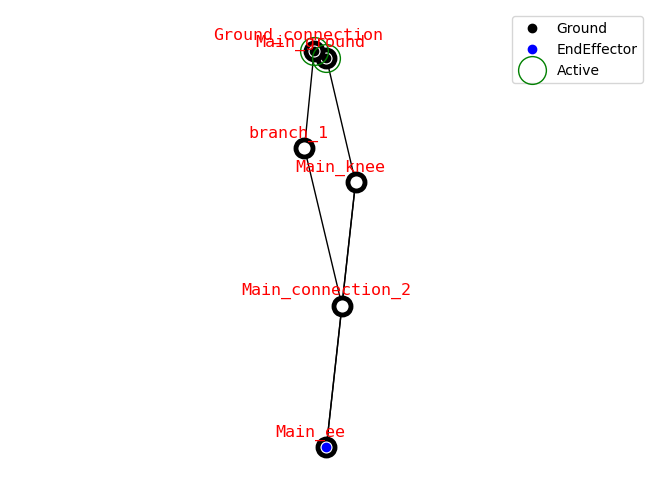

In [4]:
F = res.F
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
weights = np.array([0.5, 0.5])

decomp = ASF()
b = decomp.do(nF, 1/weights).argmin()
best_x = res.X[b]
graph = problem.graph_manager.get_graph(best_x)
draw_joint_point(graph)

One can specify the graph from other sources or build it from generator

In [5]:
# graph = problem.graph_manager.get_graph(problem.graph_manager.generate_central_from_mutation_range())
# draw_joint_point(graph)

The saved results includes the description of the rewards and trajectories, also the soft constrain part.  
A simple visualization of trajectories and mech.

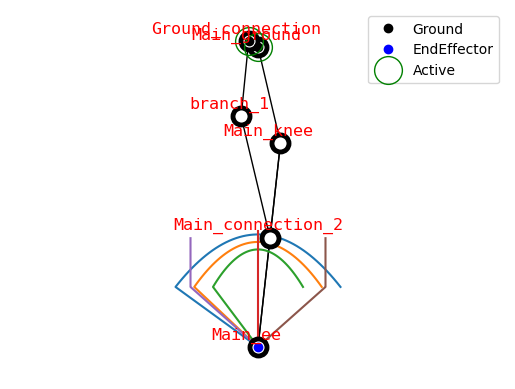

In [6]:
reward_manager = problem.rewards_and_trajectories

for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

draw_joint_point(graph)
plt.show()

Builder and criterion aggregator can both be obtained from the saved data.

In [7]:
builder = problem.builder
crag = problem.rewards_and_trajectories.crag
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)

One can get a trajectory from the reward manager and calculate the trajectory following data.

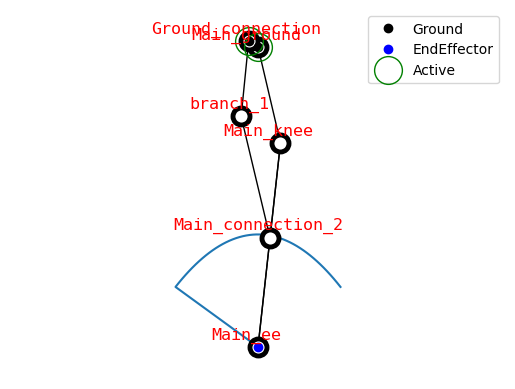

In [8]:
trajectory = problem.rewards_and_trajectories.trajectories[0]

plt.plot(trajectory[:, 0], trajectory[:, 2])
draw_joint_point(graph)
plt.show()

At first one should check the soft constrains on the selected trajectory for the selected mechanism. If the value is zero the mechanism can follow the selected trajectory. 

In [9]:
constrain_error, results = problem.soft_constrain.calculate_constrain_error(
    crag, fixed_robot, free_robot)
constrain_error

0.0

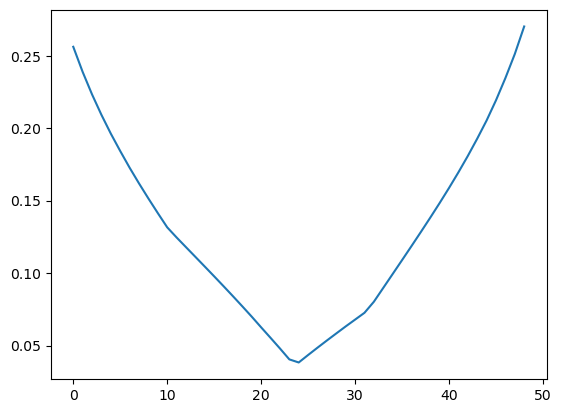

In [10]:
#plt.plot(np.sum(np.diff(res_dict_fixed['q'], axis=0),axis=1))
plt.plot(np.sum(np.abs(np.diff(results[0][2]['q'], axis=0)),axis=1))

Using the calculated data one can get any reward from the total reward list, even rewards that were not used in the optimization.  
But there can appear a problem that some data are not calculated with the criterion aggregator from the optimization. Therefore for some criteria one need to create new aggregator

In [11]:
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)
point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]

Reward - IMF at the end points of a trajectory.

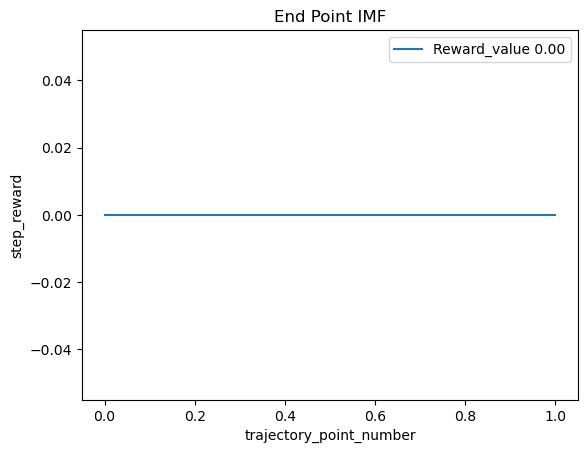

In [12]:
reward_class = EndPointIMFReward(imf_key='IMF', trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()


In [13]:
reward_class = MassReward(mass_key='MASS')
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
print("Mass of the robot:", round(reward,3))

Mass of the robot: -2.834


Actuated mass is a determinant of the mass matrix and the reward is the mean value along the trajectory

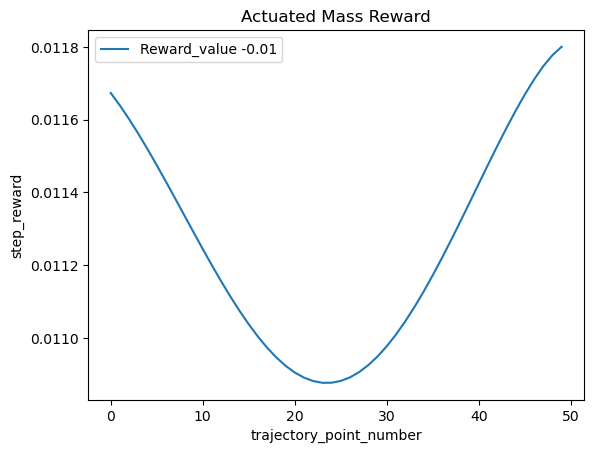

In [14]:
reward_class = ActuatedMassReward(mass_key='Actuated_Mass')
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

mean Z-IMF along the trajectory.  

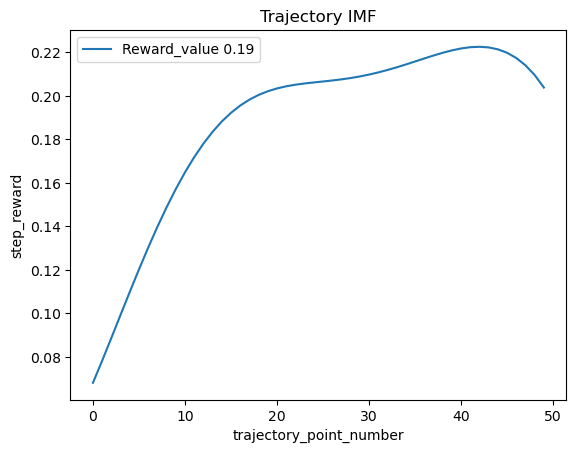

In [15]:
reward_class = TrajectoryIMFReward(imf_key='IMF',trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

mean tangent manipulability along the trajectory

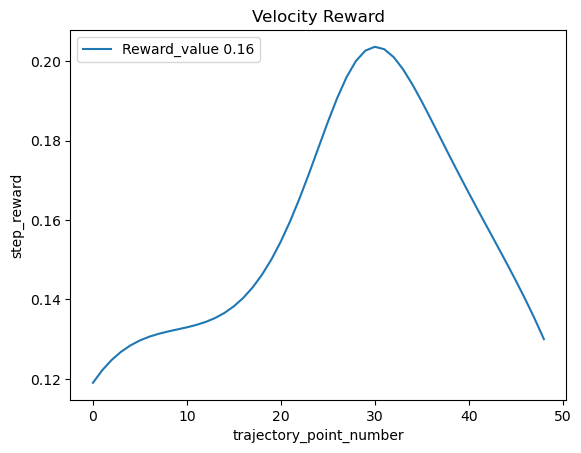

In [16]:
reward_class = VelocityReward(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

mean determinant of the manipulability matrix

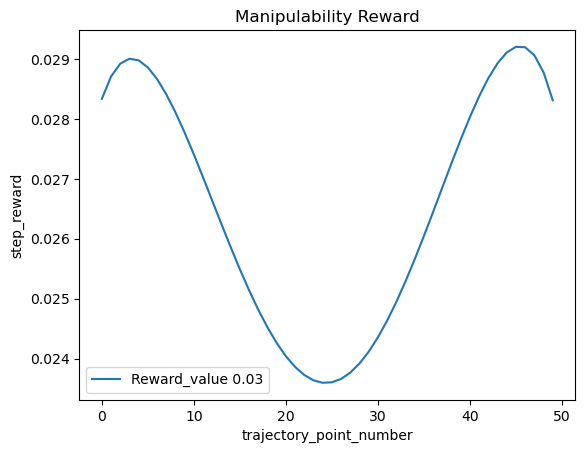

In [17]:
reward_class = ManipulabilityReward(manipulability_key='MANIP',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

min eigenvalue of the manipulability matrix

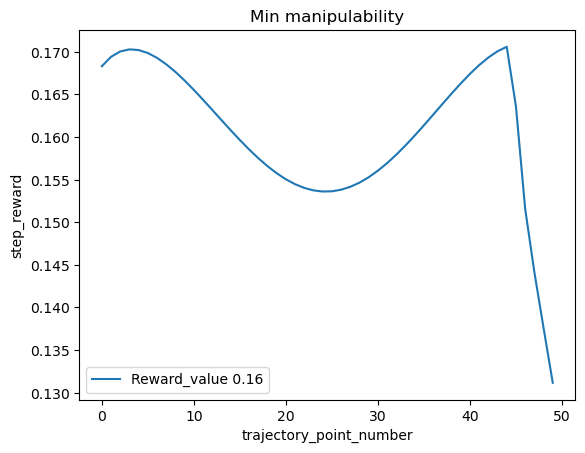

In [18]:
reward_class = MinManipulabilityReward(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

force capability along the trajectory - the force that can be withstand from the direction of the trajectory using unit torque

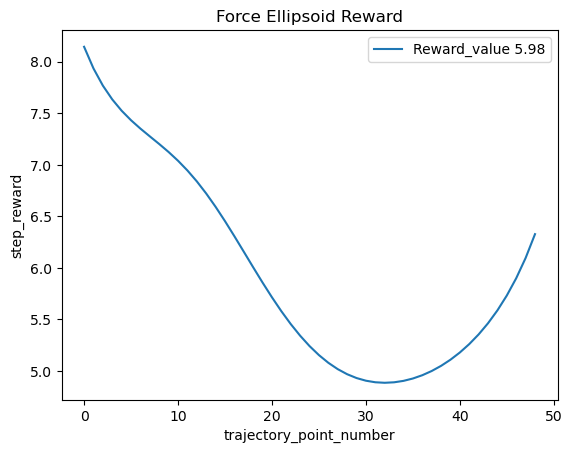

In [19]:
reward_class = ForceEllipsoidReward(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

minimal force capability which is equal to 1/max_eigenvalue. 

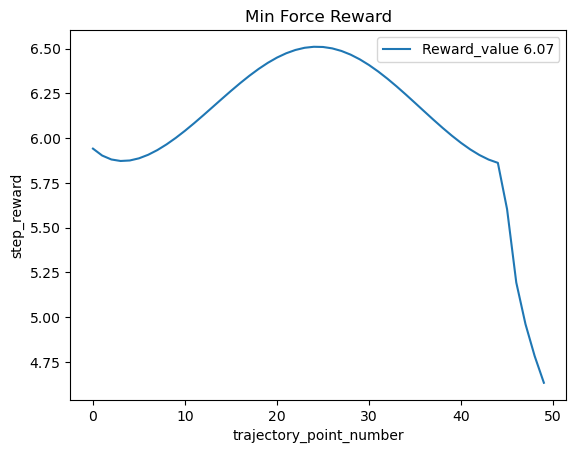

In [20]:
reward_class = MinForceReward(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

Redaction ratio in z direction in the end points of the trajectory.

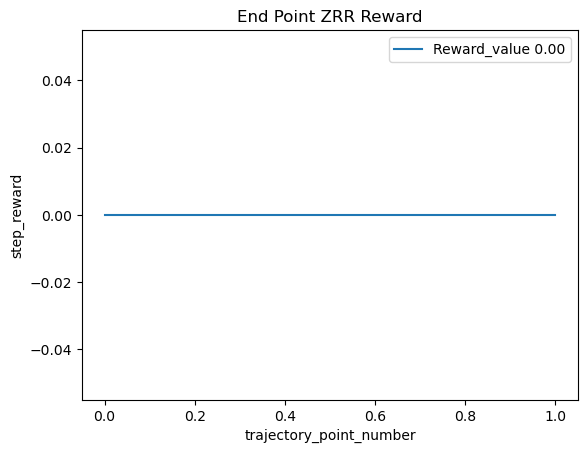

In [21]:
reward_class = EndPointZRRReward(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

Reduction ratio in z direction along the trajectory

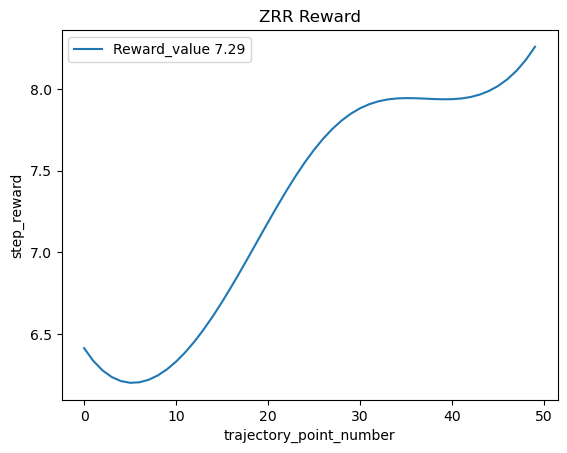

In [22]:
reward_class = ZRRReward(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

dexterity index min_eigenvalue/max_eigenvalue along the trajectory

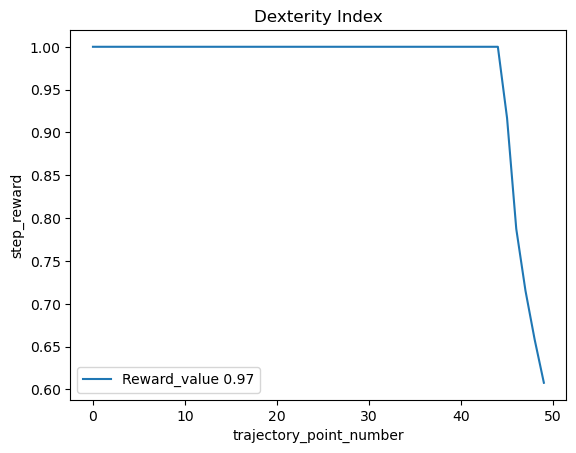

In [23]:
reward_class = DexterityIndexReward(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

The weight the mechanism can withstand at certain actuator capacity. The reward is the minimum value along the trajectory, so it is the weight it can carry along the whole trajectory  

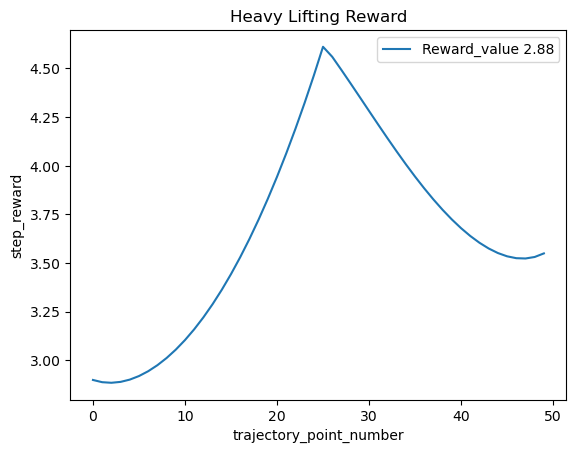

In [24]:
reward_class = HeavyLiftingReward(manipulability_key='Manip_Jacobian',mass_key='MASS',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

At each point the acceleration capability is an acceleration that can be achieved by stationary mechanism using certain percentage of the actuator capacity. 

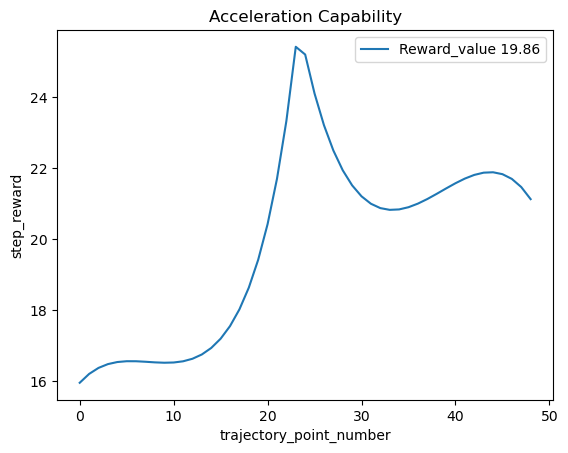

In [25]:
reward_class = AccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

The minimum acceleration capability at the point. Evaluates the ability to move in least favored direction

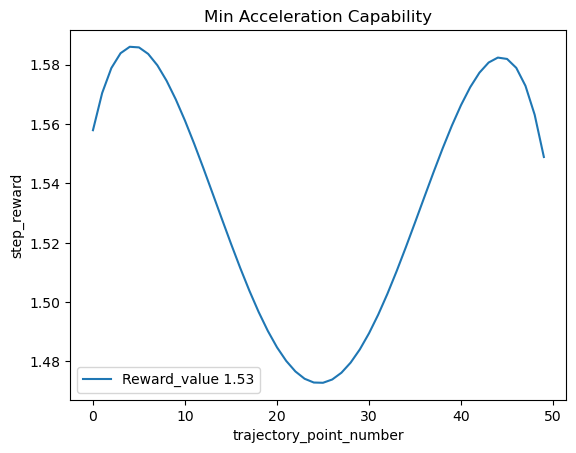

In [26]:
reward_class = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()

The variant of heavy lifting reward that evaluates the mean weight the mech can carry.

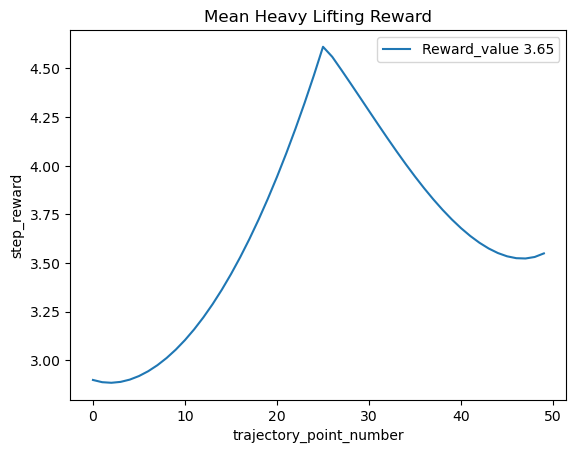

In [27]:
reward_class = MeanHeavyLiftingReward(manipulability_key='Manip_Jacobian',mass_key='MASS',
                                                    trajectory_key="traj_6d", error_key="error")
reward, reward_list = reward_class.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title(reward_class.reward_name)
plt.legend([f'Reward_value {reward:.2f}'])
plt.show()


All above manipulations can be applied to any trajectory.

In [28]:

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))
# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(
    error_calculator=error_calculator, points=[workspace_trajectory])
constrain_error, results = soft_constrain.calculate_constrain_error(
    problem.rewards_and_trajectories.crag, fixed_robot, free_robot)
constrain_error
#point_criteria_vector, trajectory_criteria, res_dict_fixed = problem.rewards_and_trajectories.crag.get_criteria_data(fixed_robot, free_robot, workspace_trajectory)

0.17500000000000002

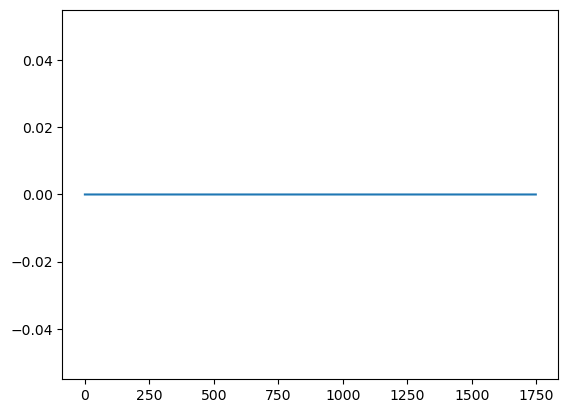

In [29]:
plt.plot(np.sum(np.abs(np.diff(results[0][2]['q'], axis=0)),axis=1))

In [30]:
from auto_robot_design.pinokla.criterion_agregator import calculate_quasi_static_simdata
from pinocchio.visualize import MeshcatVisualizer
import meshcat
viz = MeshcatVisualizer(fixed_robot.model, fixed_robot.visual_model, fixed_robot.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
calculate_quasi_static_simdata(free_robot, fixed_robot,'EE', trajectory, viz=viz)
pass

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
